# ДЗ 4: Статистика

In [1]:

%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

steklovata2.csv - временной ряд, содержащий данные о популярности музыкальной группы "Стекловата" в месяц по всему миру, с 1 ноября 2007 по 1 ноября 2017 года. Единица измерения - баллы (шкала вычислена самим google.trends)

Ссылка на данные:
https://trends.google.ru/trends/explore?date=2007-11-01%202017-11-01&q=%2Fg%2F122czk6t

In [60]:
data = pd.read_csv("steklovata2.csv", index_col=0, names = ['q'], parse_dates=True)
data.size
data.head()

,q
2007-11-01,33
2007-12-01,47
2008-01-01,40
2008-02-01,18
2008-03-01,13


### Изучим данные

Визуализируем:

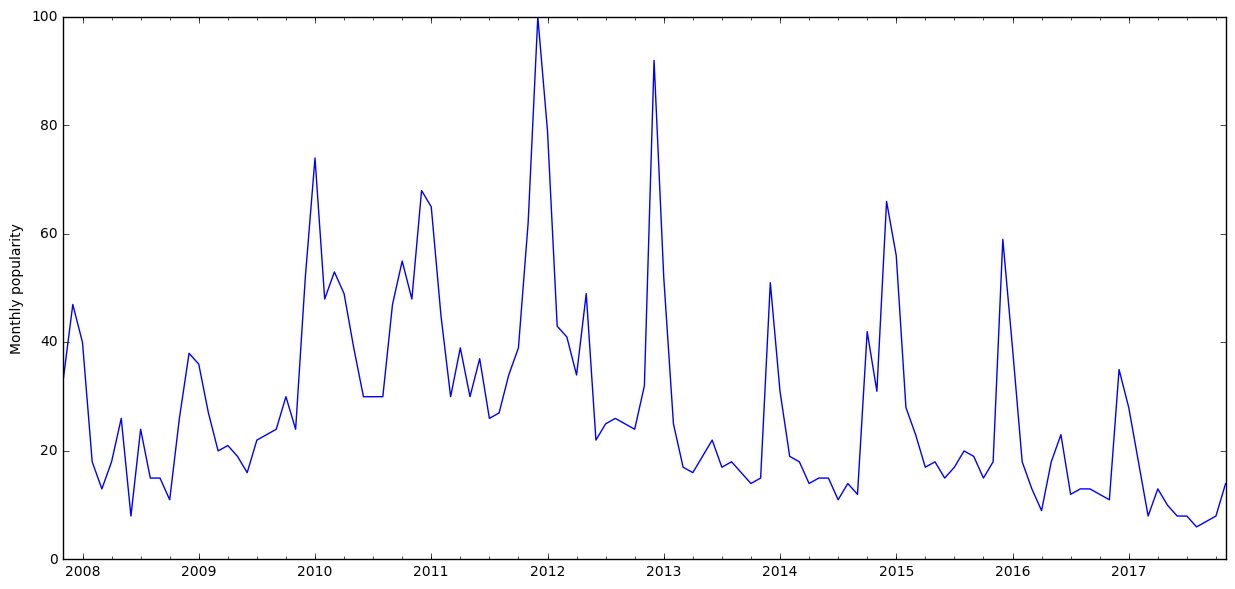

In [61]:
plt.figure(figsize(15,7))
data.q.plot()
plt.ylabel('Monthly popularity')
pylab.show()

Тест Дики-Фуллера для data.q
В качестве нулевой гипотезы рассматривается наличие единичного корня (unit root, один из корней характеристического полинома лежит на единичной окружности), т.е. нестационарность ряда.

In [62]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.q)[1])

Критерий Дики-Фуллера: p=0.666467


Поскольку значение p-value велико (p=0.666467), то нет оснований отвергать гипотезу о наличии единичного корня (ряд можно считать нестационарным).

[]

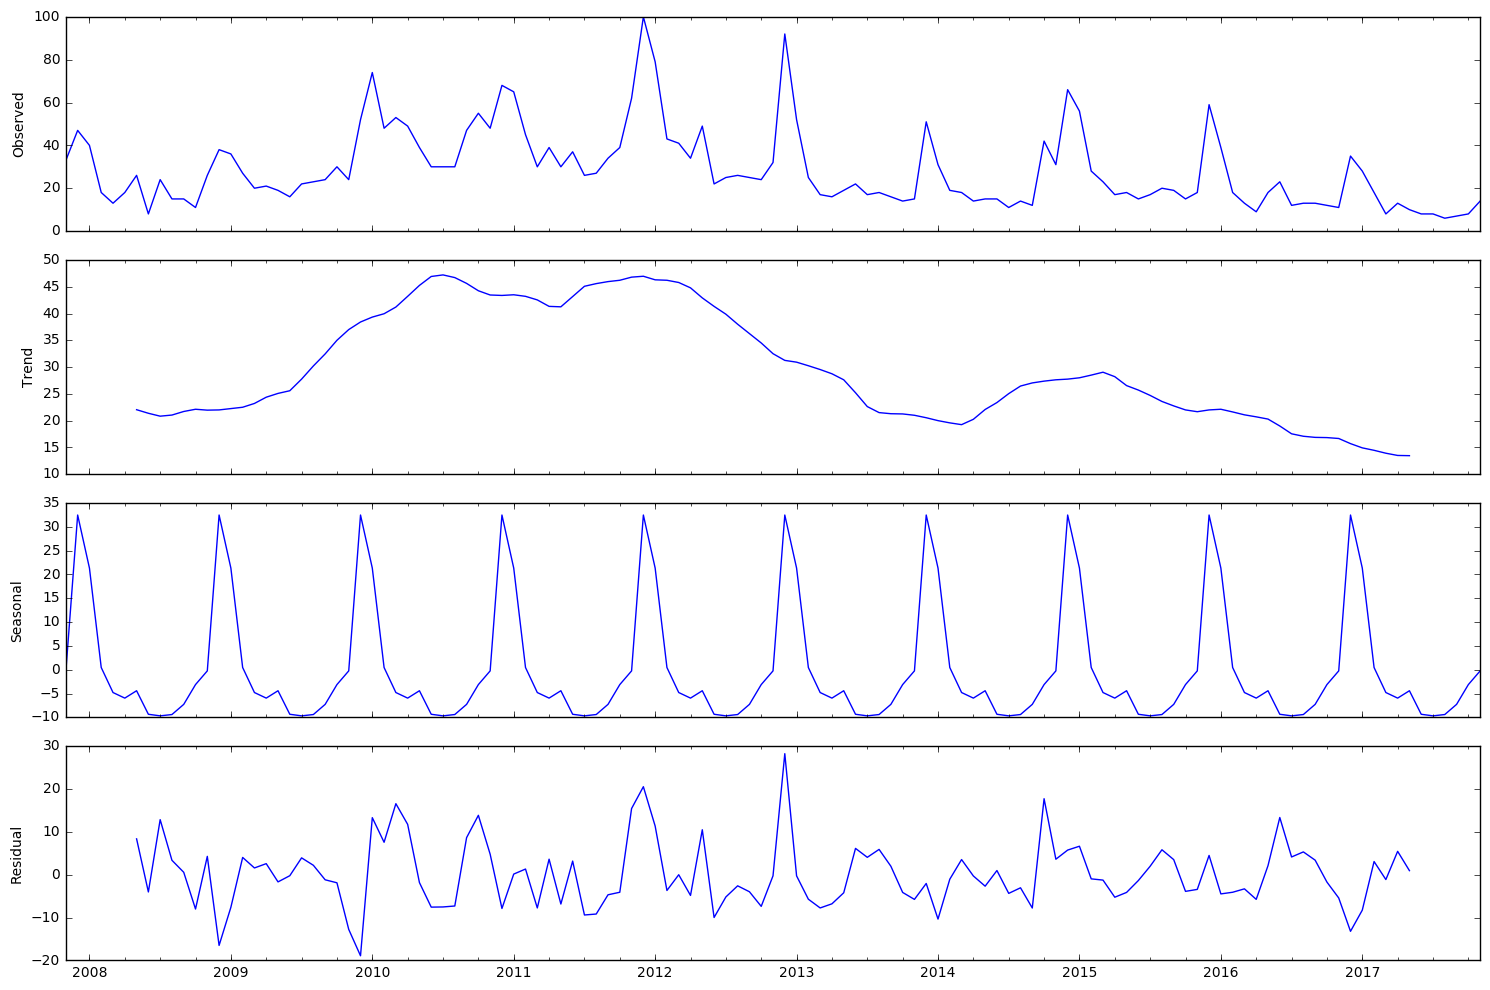

In [63]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.q).plot()
plt.plot()

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: -0.059812
Критерий Дики-Фуллера: p=0.871795


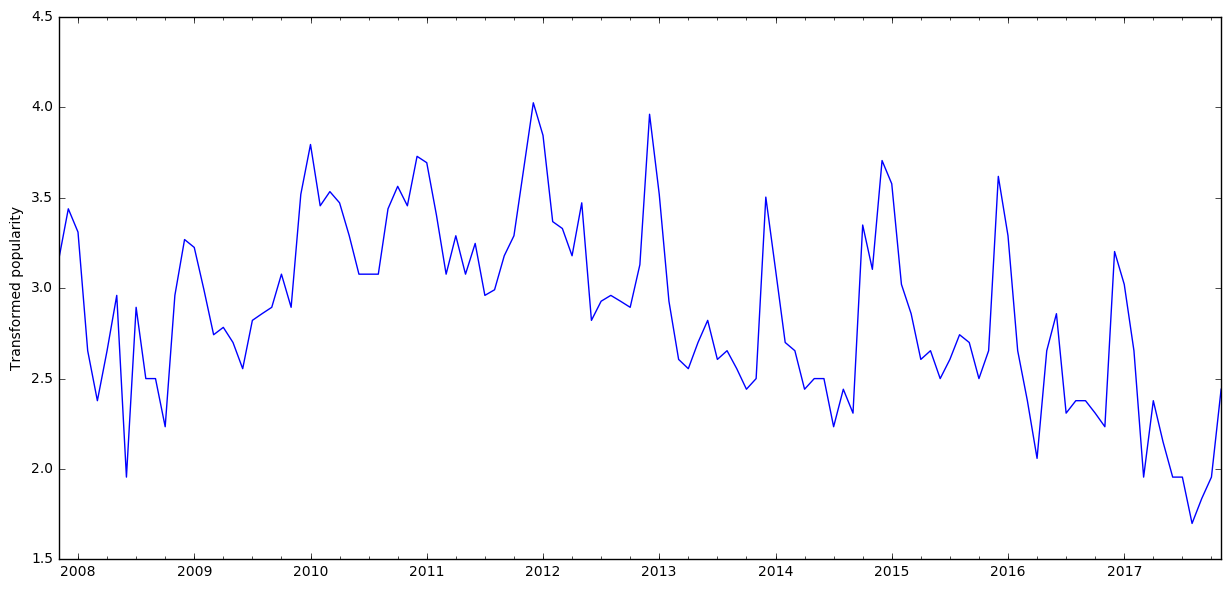

In [64]:
data['box_cox'], lmbda = stats.boxcox(data.q)
plt.figure(figsize(15,7))
data.box_cox.plot()
plt.ylabel(u'Transformed popularity')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_cox)[1])

### Стационарность и тренд

Дифференцируем. Период = 12 (пики на стыке годов)

Критерий Дики-Фуллера: p=0.211291


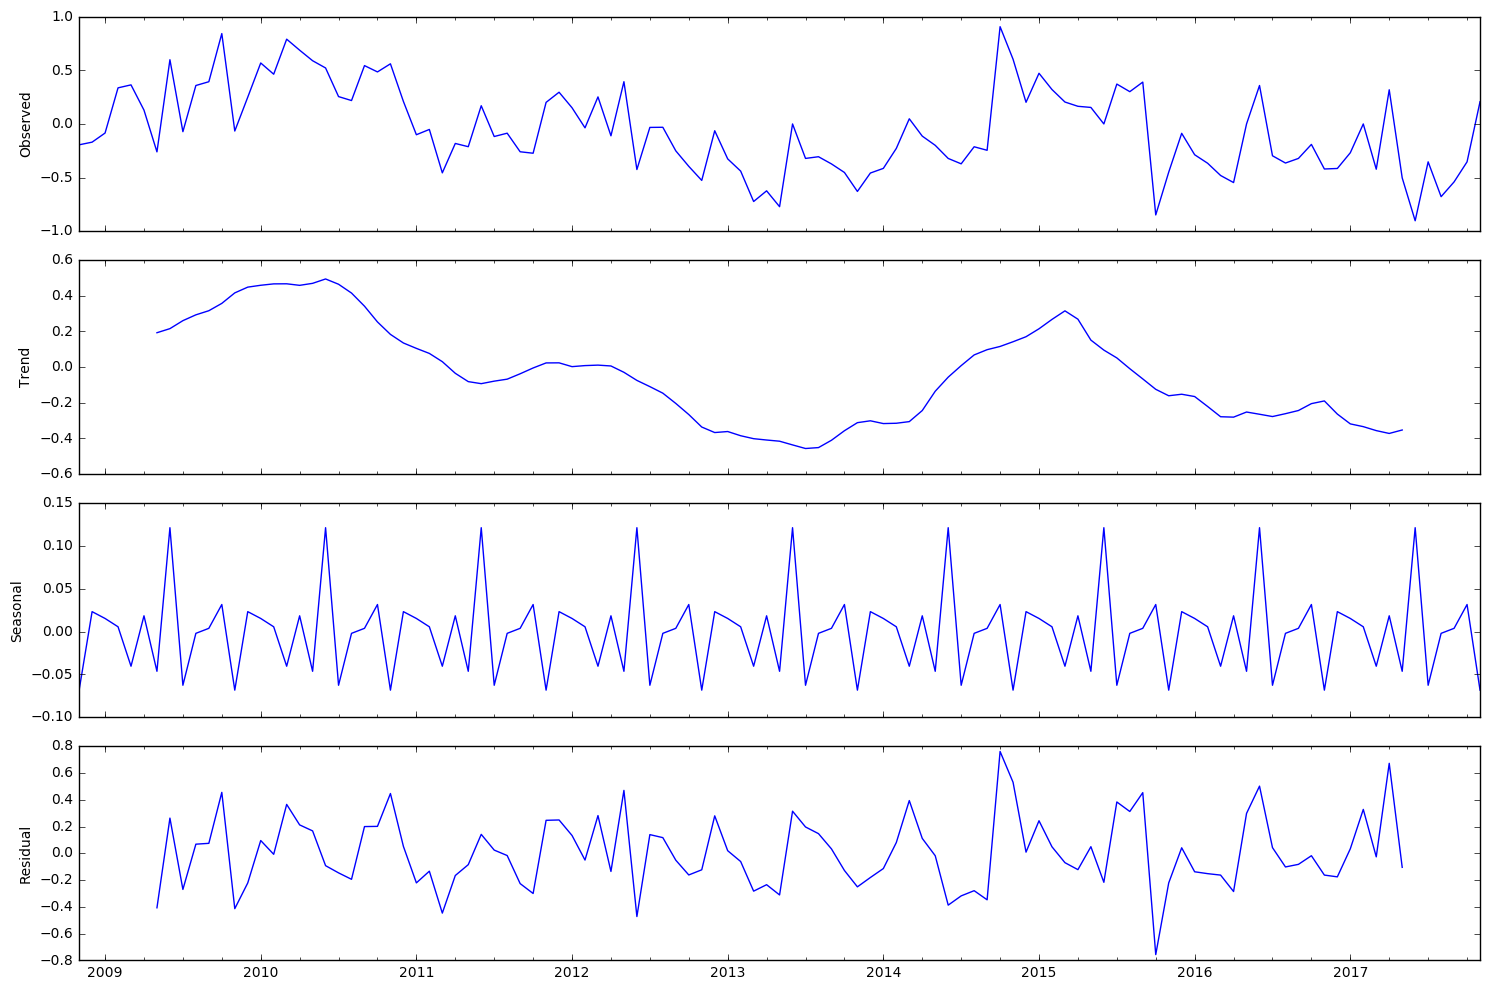

In [65]:
data['box_cox_diff'] = data.box_cox - data.box_cox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_cox_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_cox_diff[12:])[1])

Попробуем продифференцировать еще.

Критерий Дики-Фуллера: p=0.022754


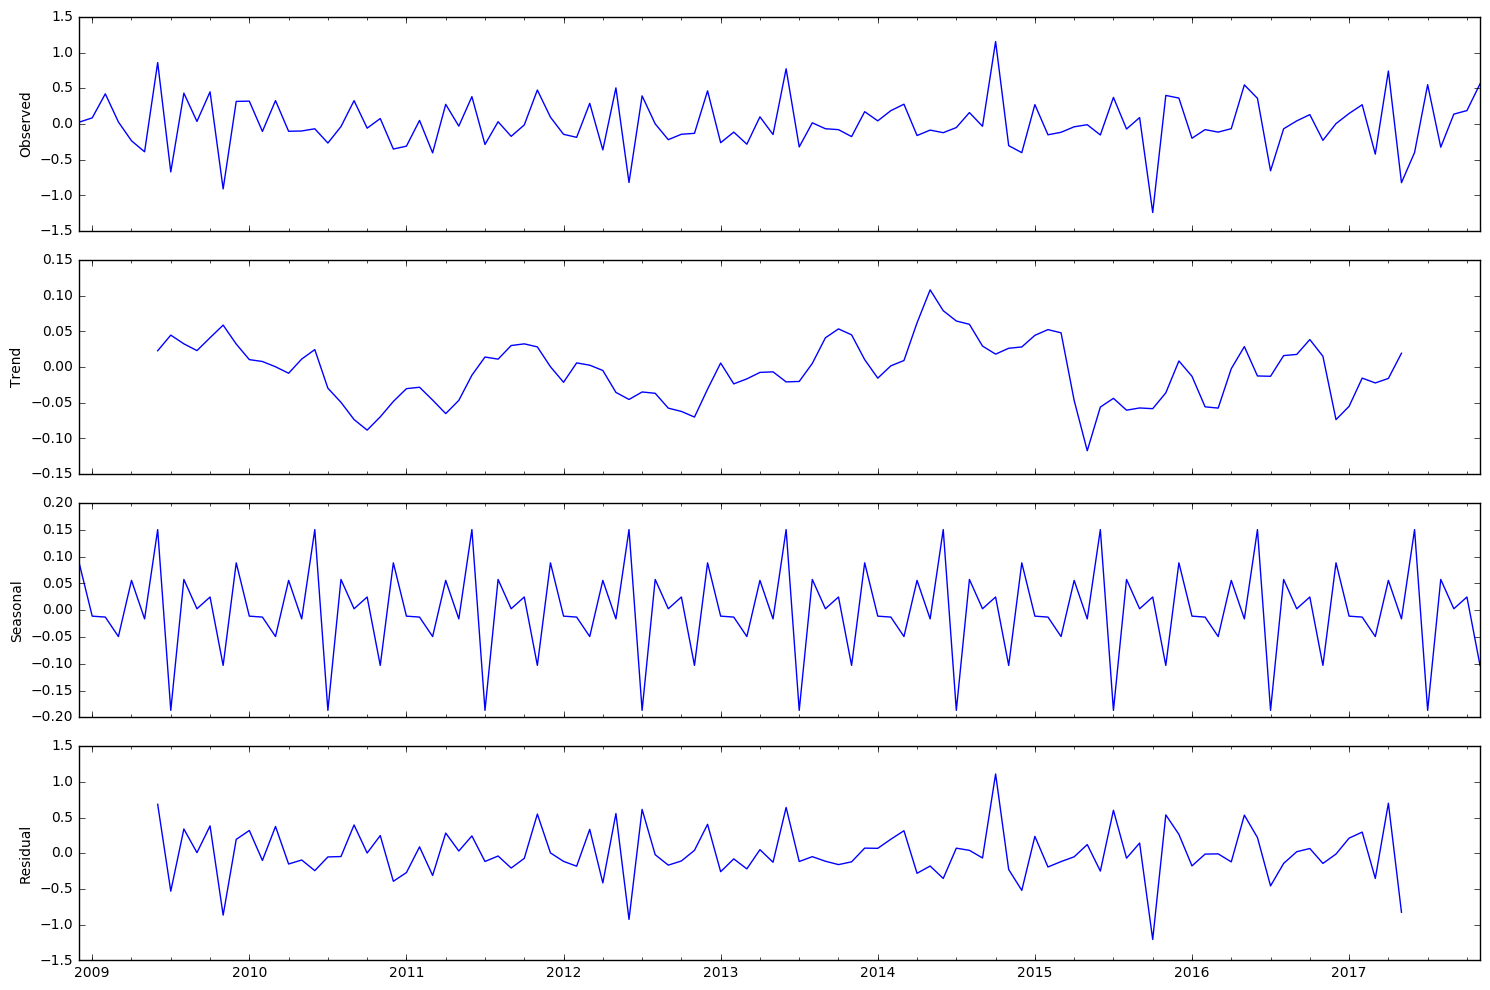

In [66]:
data['box_cox_diff2'] = data.box_cox_diff - data.box_cox_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_cox_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_cox_diff2[13:])[1])

И еще разок

Критерий Дики-Фуллера: p=0.000203


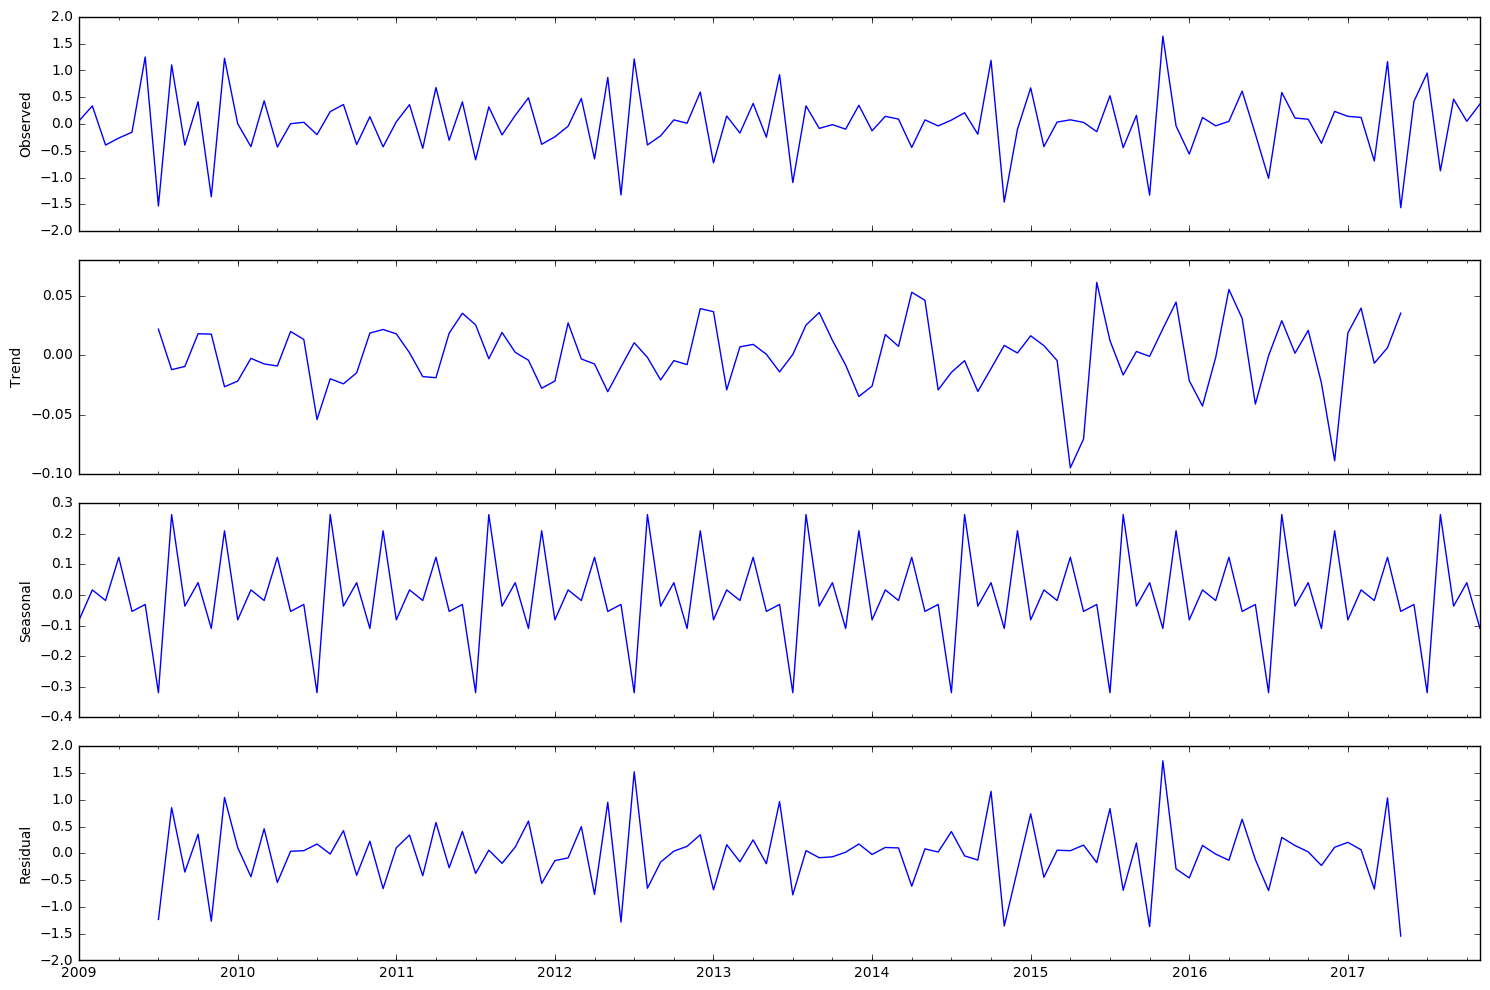

In [67]:
data['box_cox_diff3'] = data.box_cox_diff2 - data.box_cox_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_cox_diff3[14:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_cox_diff3[14:])[1])

Поскольку p-значение мало (p=0.000203), то с уровнем значимости 0.01 данный ряд можно считать стационарным (отвергнута гипотеза о наличии единичного корня).
Тренд отсутствует (смотрим график "Trend")

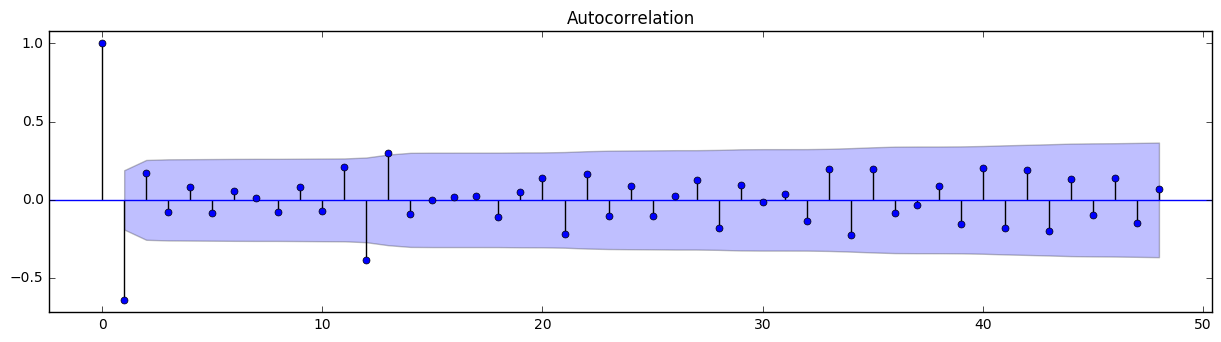

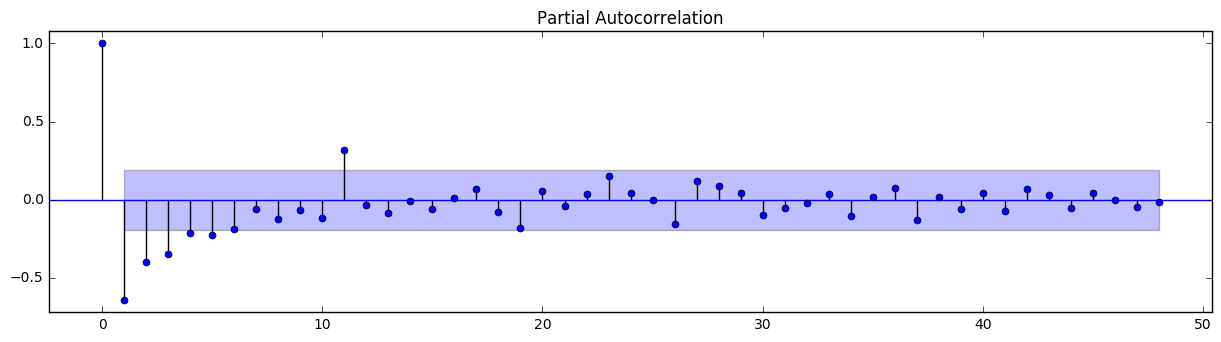

In [68]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.box_cox_diff3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.box_cox_diff3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения:

In [69]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


60

Ищем лучшую модель

In [70]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box_cox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 33.1 s


In [71]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
4   (0, 1, 0, 1)  29.293206
16  (1, 1, 0, 1)  30.915320
8   (0, 2, 0, 1)  30.950638
6   (0, 1, 1, 1)  31.266715
18  (1, 1, 1, 1)  32.867014
                                 Statespace Model Results                                 
Dep. Variable:                            box_cox   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -11.647
Date:                            Mon, 11 Dec 2017   AIC                             29.293
Time:                                    11:02:02   BIC                             37.681
Sample:                                11-01-2007   HQIC                            32.700
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

Изучим остатки

Критерий Стьюдента: p=0.593713
Критерий Дики-Фуллера: p=0.000000


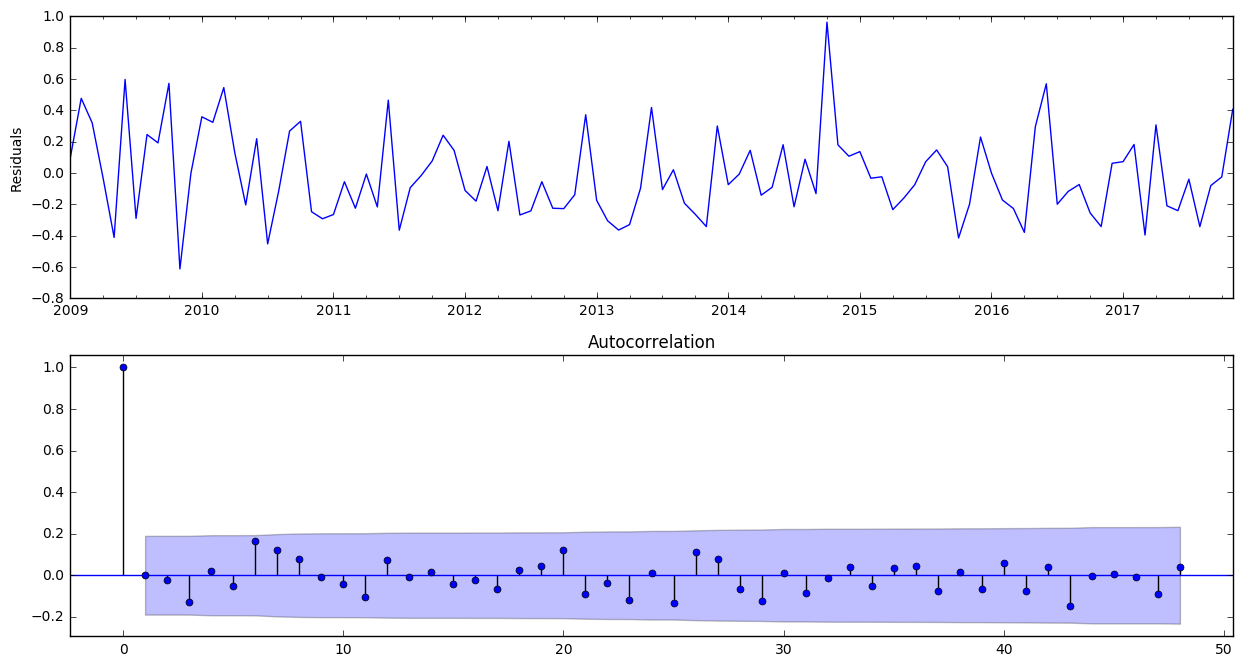

In [72]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

Все лаги попадают в доверительный интеревал, остатки неавтокоррелированные. Ряд остатков можно считать стационарным: тест Дики-Фуллера с p=0.00. Остатки несмещены (подтверждается критерием Стьюдента)

### Предсказания

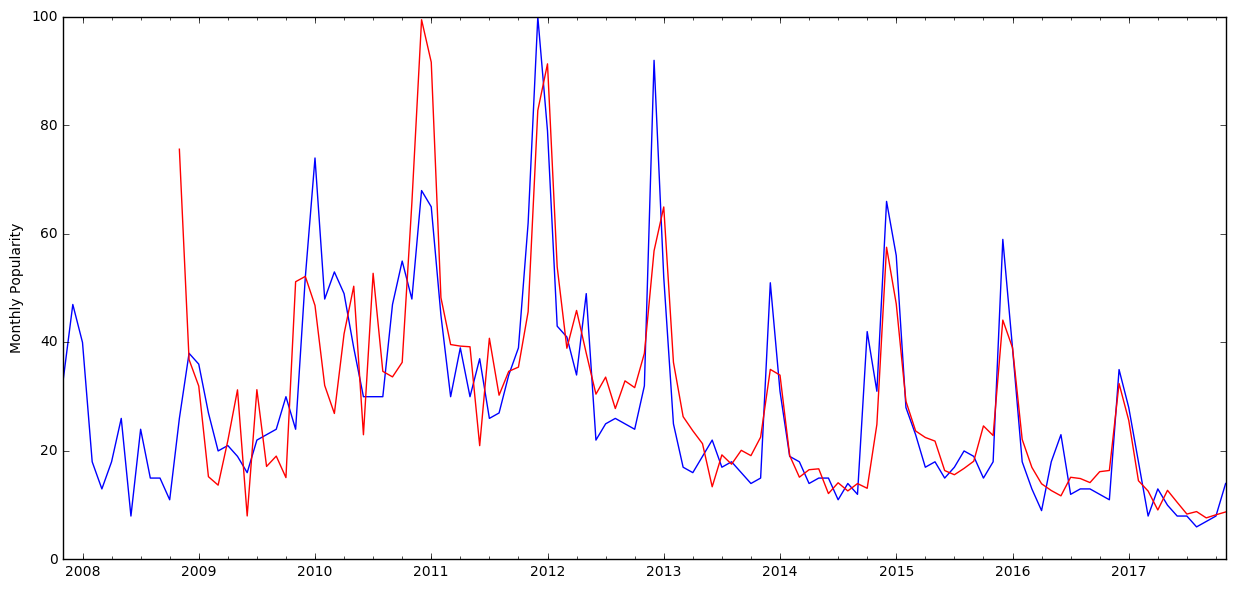

In [73]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.q.plot()
data.model[12:].plot(color='r')
plt.ylabel('Monthly Popularity')
pylab.show()

Точность оставляет желать лучшего. Новогодние пики угадываются неплохо - особенно последние три года

Предскажем на три года вперед.

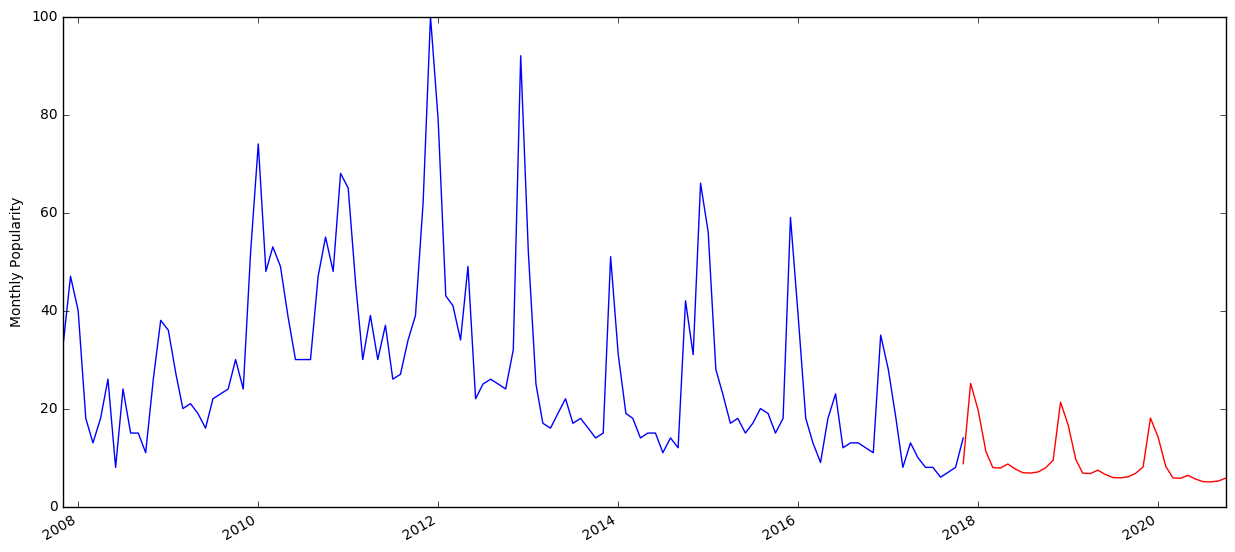

In [74]:
data2 = data[['q']]
date_list = [datetime.datetime.strptime("2017-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=120, end=155), lmbda)

plt.figure(figsize(15,7))
data2.q.plot()
data2.forecast.plot(color='r')
plt.ylabel('Monthly Popularity')
pylab.show()

Нисходящий тренд, периодичность - год, пики - конец декабря.

Похоже на правду